<a href="https://colab.research.google.com/github/HHansi/Applied-AI-Course/blob/main/Image%20Processing/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bumble Bee or Honey Bee?

This notebook contains the practical examples and exercises for the Applied AI-Image Processing.

*Created by Hansi Hettiarachchi*

![](https://github.com/HHansi/Applied-AI-Course/blob/main/Image%20Processing/images/Honey-Bee-V.-Bumble-Bee.png?raw=true) <br>
[image source](https://www.modernpest.com/blog/bumble-bees-vs-honeybees/)

Gaining insight into changing bee populations is critical to understanding the effects of colony collapses. Bee images were used as an easy way to gather the details. However, experts need to manually analyse the images to identify each bee type. Let's look for a machine learning-based solution to make this identification simpler and more efficient.

More details about this challenge are available [here](https://www.drivendata.org/competitions/8/).


In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt

# library for evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# libraries for ML algorithms
from sklearn import svm

from random import randint
from random import seed

RANDOM_SEED = 100

# Drive and File Setup

In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If your data is in a .zip file within the drive, you can use the following code to unzip it.

<font color='red'>You need to run this code once. When you unzip your data, the unzipped folder will remain in your Drive.</font>

<font color='red'>Note: Please make sure to update the following paths according to your saved locations.</font>

In [ ]:
# unzip file
import shutil
shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/Applied-AI/Image Processing/data/bee_dataset.zip', '/content/drive/MyDrive/Colab Notebooks/Applied-AI/Image Processing/data', 'zip')

#Load image dataset

In [ ]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/Applied-AI/Image Processing/data/bee_dataset'

In [ ]:
# load training data
df_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 3969


,id,genus
0,520,1.0
1,3800,1.0
2,3289,1.0
3,2695,1.0
4,4922,1.0


In [ ]:
# load testing data
df_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 6


,id
0,1
1,2
2,3
3,4
4,5


<Axes: xlabel='genus', ylabel='count'>

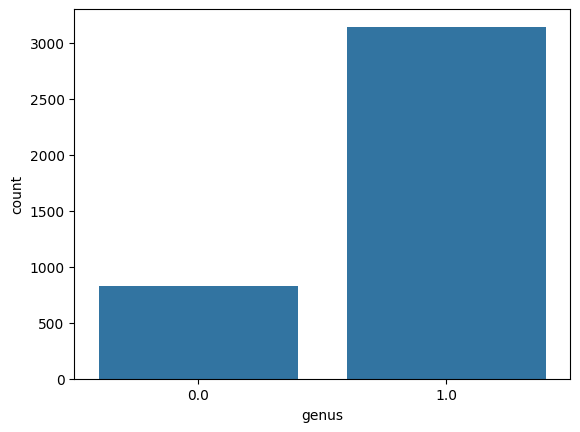

In [ ]:
# Summarise label details in training data
sns.countplot(x=df_train['genus'])

Train and test images are available in separate folders.

Let's write a function to load images.

In [ ]:
# method to load images in a folder
def load_images(ids, folder_path, dim=None):
  '''
  ids: list of image ids
  folder_path: path to image folder
  dim: dimensions to resize images (optional)
  '''
  images = []
  for id in tqdm(ids):
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

    # Resize if necessary
    if dim is not None:
      if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
        img = cv2.resize(img, dim)
    images.append(img)
  return images

When converting an image to a vector, the final vector length depends on the image's original dimensions. Also, we need the same length vectors for the model as features.

Thus, if the images are in different sizes, converting them into a common dimension during the image loading makes the following steps easier.

In [ ]:
base_dim = (200, 200)

# load train images
train_image_folder = os.path.join(data_folder, 'train_images')
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join(data_folder, 'test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

100%|██████████| 3969/3969 [21:37<00:00,  3.06it/s]


Number of training images loaded: 3969


100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

Number of testing images loaded: 6


# Image pre-processing, feature extraction and model generation

Let's train some machine learning models using different combinations of preprocessing and feature extraction techniques.

As classification algorithms, you learned various algorithms such as SVM, Naive Bayes and decision trees under the Machine Learning module. To make things simpler, let's focus on SVM for our initial experiments to understand the impact of different data preprocessing techniques and features. Later, we can extend the experiments to other algorithms.

Let's define some combinations to try out in our initial experiments, from simple to complex features.

|Model | Data Preprocessing | Features   |
|------|--------------------|------------|
|M1    |gray scaling| image vector |
|M2    |gray scaling, smoothing| image vector |
|M3    |gray scaling | edge vectors (Canny) |
|M4    |gray scaling | HoG vectors |

<b>NOTE!</b> All possible combinations are not listed here.

Since we need to evaluate all the models we are going to build using the same procedure, we can write a function for evaluation, which we can reuse for each model without repeatedly writing the same code.

In [ ]:
# method to calculate evaluation results
def evaluate(actuals, predictions, class_names):
  '''
  actuals: list of actual labels
  predictions: list of predicted labels
  class_names: list of classes used for the model/classification task
  '''
  # calculate accuracy
  accuracy = metrics.accuracy_score(actuals, predictions)
  print(f'Accuracy: {accuracy}')

  # plot confusion matrix
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=class_names)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
  disp.plot()
  plt.show()

## SVM

Similar to our approach to evaluation, we can write a function to build an SVM model as follows.

In [ ]:
# method to train and predict using SVM classifier
def get_svm_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, clf.classes_)

  return clf

### Model M1

- Preprocessing - gray scaling<br>
- Features - image vector<br>
- Algorithm - SVM <br>

To convert images to vectors following gray scaling, we need to apply the same process to each image.

It is easy to write a function for a such repetetive task, which we need to perform for train, validation and test images.

In [ ]:
# method to get image features
def get_features_m1(images):
  '''
  images: list of images
  '''
  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # image vectorisation/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Let's apply the above function to all train images to convert them into feature vectors.

In [ ]:
# feature extraction
features_train = get_features_m1(train_images)
print(features_train.shape)

(3969, 40000)


As the next step, we need to get a split from training data for model validation.

Then, we can train our first SVM model and evaluate it on the validation set.

In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.7027707808564232


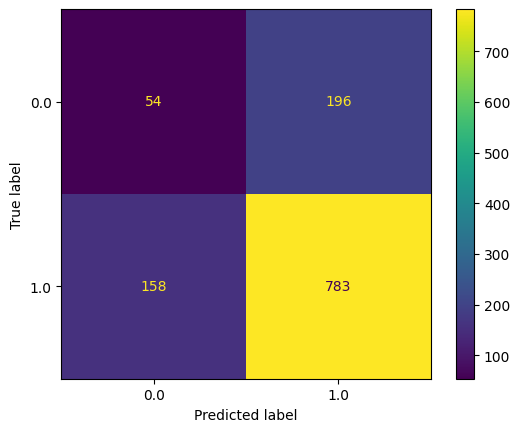

In [ ]:
# train model
m1 = get_svm_predictions(X_train, X_val, y_train, y_val)

Since image models take longer to train, let's make predictions for test data and keep them saved for later analyses.

In [ ]:
# feature extraction - test data
features_test = get_features_m1(test_images)
print(features_test.shape)

# get model predictions
predictions = m1.predict(features_test)
print(predictions)

(6, 40000)
[1. 1. 0. 0. 1. 0.]


### Model M2

- Preprocessing - gray scaling, smoothing <br>
- Features - image vector<br>
- Algorithm - SVM <br>

To smooth images, we learned two commonly used techniques: (1) box filtering and (2) Gaussian filtering. From them, Gaussian filtering is used in this example.

Let's pick a random sample from images to see how smoothing affects them and to get an idea of suitable parameter settings.

**NOTE!** This part is optional for the main flow.

Image Id: 596
Image Id: 1882
Image Id: 1863
Image Id: 3898
Image Id: 3157


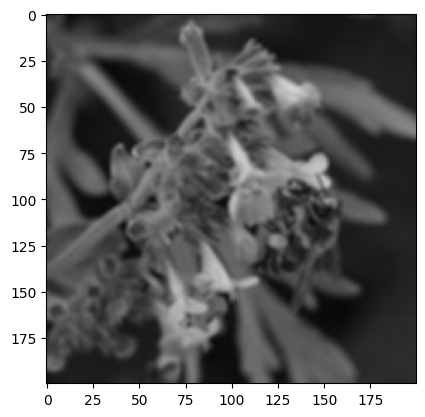

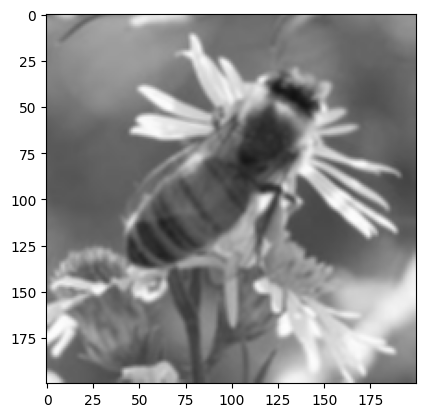

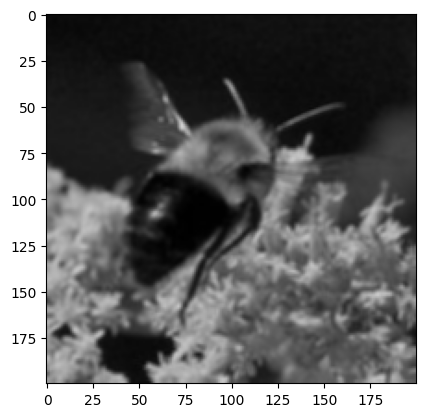

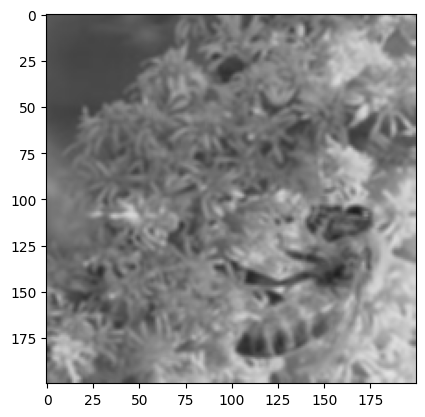

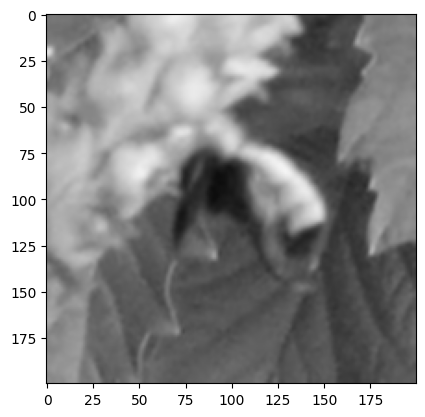

In [ ]:
seed(RANDOM_SEED)
sample_images = []

# pick a random sample of images
for i in range(5):
  value = randint(0, len(train_images)-1)
  print(f'Image Id: {value}')
  sample_images.append(train_images[value])

# apply preprocessing and show output images
for img in sample_images:
  img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)

  plt.imshow(cv2.cvtColor(img_blurred, cv2.COLOR_BGR2RGB))
  plt.show()

Following our initial assessment, we can fix the hyper-parameter values required for pre-processing and write a method as below to extract features from images.

In [ ]:
# method to get image features
def get_features_m2(images):
  '''
  images: list of images
  '''
  features_list = []
  for img in images:
    # image preprocessing - gray scaling + smoothing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)

    # image vectorisation/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Let's apply the above function to all train images to convert them into feature vectors.

In [ ]:
# feature extraction
features_train = get_features_m2(train_images)
print(features_train.shape)

(3969, 40000)


Now, we can create train and validation splits and train the model.

Accuracy: 0.6817800167926112


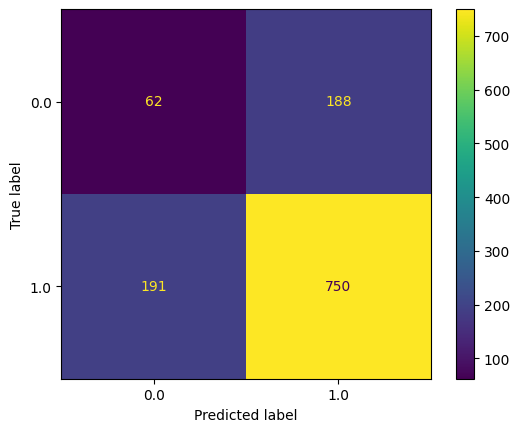

In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m2 = get_svm_predictions(X_train, X_val, y_train, y_val)

Let's make predictions for test data and keep them saved for later analyses.

In [ ]:
# feature extraction - test data
features_test = get_features_m2(test_images)
print(features_test.shape)

# get model predictions
predictions = m2.predict(features_test)

print(predictions)

(6, 40000)
[0. 1. 0. 0. 1. 0.]


### Model M3

- Preprocessing - gray scaling <br>
- Features - edge map to vector<br>
- Algorithm - SVM <br>

For edge detection, we use Canny edge detection algorithm in this example.

In [ ]:
# method to get image features
def get_features_m3(images):
  '''
  images: list of images
  '''
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

In [ ]:
# feature extraction
features_train = get_features_m3(train_images)
print(features_train.shape)

(3969, 40000)


Accuracy: 0.7884130982367759


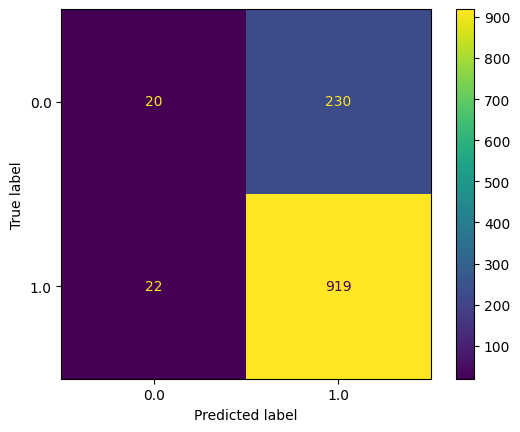

In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m3 = get_svm_predictions(X_train, X_val, y_train, y_val)

Make predictions on test images

In [ ]:
# feature extraction - test data
features_test = get_features_m3(test_images)
print(features_test.shape)

# get model predictions
predictions = m3.predict(features_test)

print(predictions)

(6, 40000)
[1. 1. 1. 1. 1. 1.]


### Model M4
- Preprocessing - gray scaling <br>
- Features - HOG features<br>
- Algorithm - SVM <br>

In [ ]:
# method to get image features
def get_features_m4(images):
  '''
  images: list of images
  '''
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

In [ ]:
# feature extraction
features_train = get_features_m4(train_images)
print(features_train.shape)

(3969, 3780)


Accuracy: 0.670864819479429


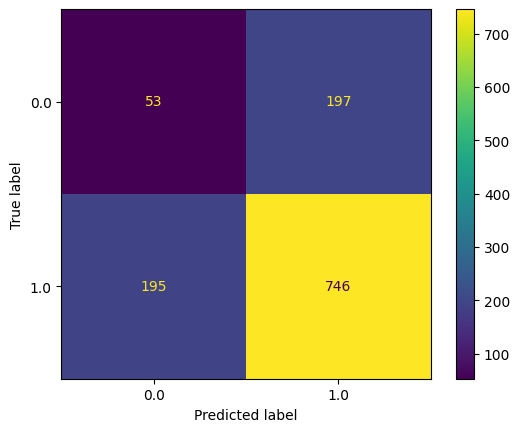

In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m4 = get_svm_predictions(X_train, X_val, y_train, y_val)

Make predictions on test images

In [ ]:
# feature extraction - test data
features_test = get_features_m4(test_images)
print(features_test.shape)

# get model predictions
predictions = m4.predict(features_test)
print(predictions)

(6, 3780)
[1. 0. 1. 1. 1. 1.]


Make predictions on test images

### Summary

Based on our findings up to now, the above table can be updated to the following version.

|Model | Preprocessing | Features   | Accuracy|
|------|---------------|------------|---------|
|M1    | gray scaling   | image vector | 0.7028 |
|M2    | gray scaling, smoothing| image vector | 0.6818 |
|M3    | gray scaling | edge map to vector | **0.7884** |
|M4    | gray scaling | HOG features | 0.6709 |

So far, we have the best accuracy for M3.

### Model M5

Let's try to combine features.

- Preprocessing - gray scaling <br>
- Features - image vector + edge map vector<br>
- Algorithm - SVM <br>

In [ ]:
# method to get image features
def get_features_m5(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

More details about numpy.hstack are available with the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html).

Train and validate model

In [ ]:
# feature extraction
features_train = get_features_m5(train_images)
print(features_train.shape)

(3969, 80000)


Accuracy: 0.7674223341729639


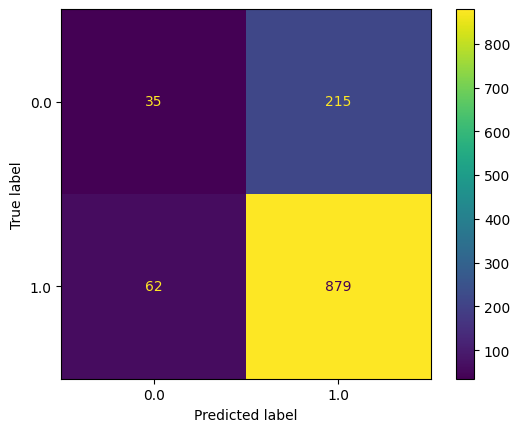

In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['genus'], test_size=0.3, random_state=RANDOM_SEED)

# train model
m5 = get_svm_predictions(X_train, X_val, y_train, y_val)

Make predictions on test images

In [ ]:
# feature extraction - test data
features_test = get_features_m5(test_images)
print(features_test.shape)

# get model predictions
predictions = m5.predict(features_test)
print(predictions)

(6, 80000)
[1. 1. 1. 1. 1. 1.]


### <font color='green'>**Activity**</font>

1. Apply PCA to the best model built above and see the impact of dimensionality reduction on the model's accuracy.

2. Check other possible image preprocessing and feature combinations and see whether they can improve the model's accuracy. Also, try tuning hyper-parameters of the SVM algorithm based on the knowledge you gained during the Machine Learning module.

3. Apply other classification algorithms you learned for this task and analyse their performance.